In [61]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import metrics
from time import time

In [2]:
drug_reviews = pd.read_csv("https://raw.githubusercontent.com/smeng0428/CIS9665/main/drug_reviews.csv")
drug_reviews.shape

(10000, 8)

In [4]:
## read in data
#train_set = pd.read_csv('drugsComTrain_raw.csv')
##val_set = pd.read_csv('drugsComTest_raw.csv')
## we are using t first 5000 for faster training time
#drug_reviews = pd.read_csv('drugsComTrain_raw.csv')
#drug_reviews = drug_reviews.copy()[:10000]
#drug_reviews.to_csv('drug_reviews.csv')

In [10]:
drug_reviews.head(5)

,Unnamed: 0,uniqueID,drugName,condition,review,rating,date,usefulCount
0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
#train_set.shape

In [5]:
#val_set.shape

In [6]:
#train_set.describe()

In [7]:
#len(set(train_set.condition))

In [8]:
#train_set.usefulCount.hist()

In [9]:
#val_set.usefulCount.hist()

In [10]:
#train_set[train_set.usefulCount==max(train_set.usefulCount)]

In [11]:
#len(set(val_set.condition))

In [12]:
#len(set(train_set.drugName))

In [13]:
#len(set(val_set.drugName))

In [14]:
#len(set(train_set.review))

In [3]:
## borrowed Jacob's codes
def replacements(string):
    replace_dict = {'"'      : '',
                    '&#039;' : "'",
                    '&amp'   : '&'}
    
    for key, value in replace_dict.items():
        string = string.replace(key, value)
        
    return string

In [4]:
drug_reviews.review = drug_reviews.review.map(replacements)

In [17]:
#train_set['sent'] = train_set.review.map(sent_tokenize)
#train_set['word'] = train_set.review.map(word_tokenize)


In [5]:
# create lemmatizer object
lancaster = nltk.LancasterStemmer()

# create function to clean text
def clean_text(s):
    
    # convert text to lowercase
    s = s.lower()
    
    # tokenize each review
    tokens = nltk.tokenize.word_tokenize(s)
     
    # stem / lemmatize each token (walked --> walk, computers --> computer, etc.)
    clean_tokens = [lancaster.stem(token) for token in tokens]

    # remove punctuation
    clean_tokens = [token for token in clean_tokens if token.isalpha()]
    
    # remove stop words
    clean_tokens = [token for token in clean_tokens if token not in nltk.corpus.stopwords.words("english")]
    
    return clean_tokens

In [14]:
drug_reviews['sent'] = drug_reviews.review.map(sent_tokenize)
drug_reviews['word'] = drug_reviews.review.map(word_tokenize)

In [15]:
drug_reviews['avg_sents'] = drug_reviews.sent.map(lambda x:len(x))
drug_reviews['avg_words'] = drug_reviews.word.map(lambda x:len(x))

In [16]:
drug_reviews['clean_tokens'] = drug_reviews.review.map(clean_text)

In [17]:
drug_reviews['avg_sents'].describe()

count    10000.000000
mean         5.939500
std          3.281328
min          1.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         41.000000
Name: avg_sents, dtype: float64

In [6]:
drug_reviews.rating.describe()

count    10000.000000
mean         6.992900
std          3.259035
min          1.000000
25%          4.750000
50%          8.000000
75%         10.000000
max         10.000000
Name: rating, dtype: float64

In [7]:
drug_reviews.condition.describe()


count              9941
unique              457
top       Birth Control
freq               1791
Name: condition, dtype: object

In [8]:
fd = nltk.FreqDist(drug_reviews.condition)

In [9]:
fd.most_common(20)

[('Birth Control', 1791),
 ('Depression', 589),
 ('Pain', 397),
 ('Acne', 356),
 ('Anxiety', 341),
 ('Bipolar Disorde', 247),
 ('Insomnia', 234),
 ('ADHD', 231),
 ('Obesity', 214),
 ('Weight Loss', 213),
 ('Emergency Contraception', 168),
 ('Diabetes, Type 2', 163),
 ('High Blood Pressure', 150),
 ('Vaginal Yeast Infection', 132),
 ('Anxiety and Stress', 117),
 ('ibromyalgia', 116),
 ('Abnormal Uterine Bleeding', 116),
 ('Migraine', 108),
 ('Smoking Cessation', 104),
 ('Panic Disorde', 99)]

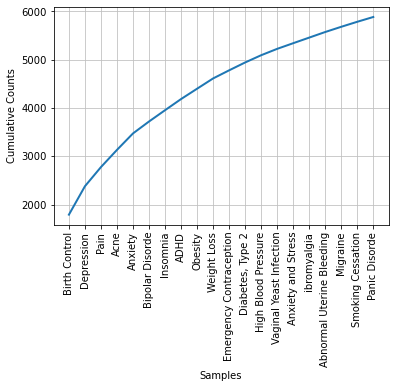

In [12]:
fd.plot(20, cumulative = True)

## 20 most common drugs represents about 60% of the reviews

## unsupervised learning methods

In [14]:
## using tf-idf to get word freq matrix
tf_idf = TfidfVectorizer(ngram_range = (1,1), stop_words = "english", lowercase = True)
## tf_idf give the result to csr_matrix format which is more efficient for sparse matrix
## it need to be transform back with toarray() method to ordinary matrix format
csr_mat = tf_idf.fit_transform(drug_reviews.review)
tf_idf_df =pd.DataFrame(csr_mat.toarray(), 
                        columns = tf_idf.get_feature_names(),
                        index = drug_reviews.index)

In [24]:
## scale the data
tf_idf_df

,00,000,000mg,000vl,00am,00for,00p,00pm,01,02,...,zyban,zyclara,zydeco,zydis,zydus,zymar,zyprexa,zyrtec,zyvox,zzzquil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)
kmeans.fit(tf_idf_df)    

KMeans(n_clusters=5)

In [31]:
labels = kmeans.predict(tf_idf_df)

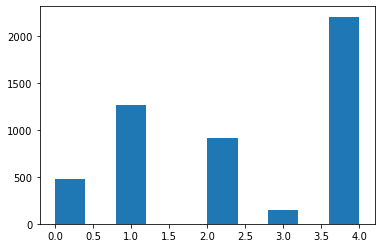

In [32]:
#plt.hist(labels)
#plt.show()

In [33]:
kmeans10 = KMeans(n_clusters = 10)
kmeans10.fit(tf_idf_df)

KMeans(n_clusters=10)

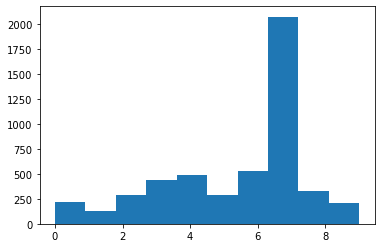

In [34]:
#labels10 = kmeans10.predict(tf_idf_df)
#plt.hist(labels10)
#plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

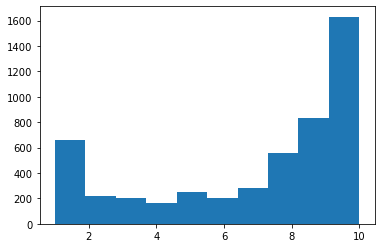

In [35]:
#plt.hist(drug_reviews.rating)
#plt.show

In [36]:
k_values = range(2,15)

inertias = []
for k in k_values:
    start = time()
    cluster = KMeans(n_clusters = k, random_state =0).fit(tf_idf_df)
    end = time()
    print('training time is '+str(end-start))
    inertias.append(cluster.inertia_)

training time is 17.685103178024292
training time is 25.017849922180176
training time is 36.16462779045105
training time is 46.83651113510132
training time is 43.96499824523926
training time is 60.14298701286316
training time is 56.46873497962952
training time is 64.45292043685913
training time is 66.76763701438904
training time is 66.23136043548584
training time is 69.71385049819946
training time is 390.70716547966003
training time is 99.04571175575256


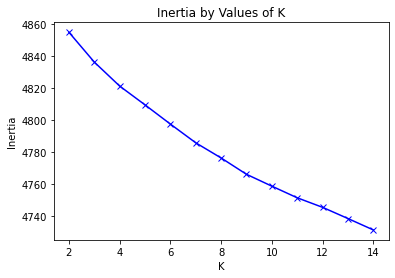

In [37]:
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Inertia by Values of K')
plt.show()

In [38]:
## there is no obvious result from the elbow method.
## 5 seems reasonable

## topic modeling with NMF

In [66]:
## NMF model for topic modeling
## chosing 5 components as 5 topics, this might need tuning.
start=time()
nmf_model = NMF(n_components=5, random_state=0)
nmf_model.fit(csr_mat)
nmf_features = nmf_model.transform(csr_mat)
end=time()
print('training time for nmf_model is '+str(end-start))

training time for nmf_model is 3.518583297729492


In [16]:
nmf_features.shape

(10000, 5)

In [17]:
## components are the topics
nmf_model.components_

array([[0.00000000e+00, 3.66780979e-03, 2.37581364e-03, ...,
        4.51694274e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.42604478e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.95838429e-04, ...,
        0.00000000e+00, 5.45751977e-05, 1.28377997e-03],
       [6.32605531e-03, 0.00000000e+00, 0.00000000e+00, ...,
        3.07824158e-03, 0.00000000e+00, 0.00000000e+00],
       [4.28657562e-02, 1.39481106e-02, 0.00000000e+00, ...,
        1.20349317e-02, 3.13603772e-03, 2.63517877e-03]])

In [18]:
## compress normalized features with conditions
nmf_df = pd.DataFrame(normalize(nmf_features), index = drug_reviews.condition)


In [23]:
## compress the topics into a data frame, the index are the word tokens from the tf_idf data which we used to train the nmf model
components_df = pd.DataFrame(nmf_model.components_, columns=tf_idf_df.columns)
## what are the most important words for the first topic 
components_df.iloc[0].nlargest(10)

anxiety       1.414755
life          0.944589
depression    0.893069
years         0.718724
medication    0.638557
panic         0.561459
effects       0.499946
attacks       0.436879
ve            0.436875
helped        0.396119
Name: 0, dtype: float64

In [47]:
##most important words for the second topic
components_df.iloc[1].nlargest(10)

period     0.981489
pill       0.783779
birth      0.768534
control    0.742624
months     0.626705
ve         0.620673
weight     0.576441
acne       0.530460
month      0.522096
periods    0.522052
Name: 1, dtype: float64

In [44]:
components_df.iloc[2].nlargest(10)

pain        2.369094
relief      0.322607
severe      0.251818
chronic     0.228251
medicine    0.212161
years       0.180932
helped      0.166879
knee        0.156400
muscle      0.153706
help        0.150763
Name: 2, dtype: float64

In [43]:
components_df.iloc[3].nlargest(10)

works       2.279566
great       1.269354
medicine    0.306163
effects     0.285117
really      0.248151
thing       0.177022
worked      0.157180
best        0.146761
use         0.140183
product     0.106614
Name: 3, dtype: float64

In [42]:
components_df.iloc[4].nlargest(10)

day        1.107916
days       0.628380
taking     0.576374
took       0.567738
feel       0.554315
like       0.527648
started    0.527510
night      0.511590
just       0.483742
felt       0.435177
Name: 4, dtype: float64

In [24]:
## takes a look at the nmf features for ADHD condition
nmf_df.loc['ADHD']

,0,1,2,3,4
condition,,,,,
ADHD,0.039677,0.177203,0.001863,0.000000,0.983372
ADHD,0.615614,0.233222,0.185736,0.107400,0.721523
ADHD,0.415059,0.018341,0.141479,0.000000,0.898539
ADHD,0.351338,0.000000,0.000000,0.000000,0.936249
ADHD,0.130487,0.000000,0.000000,0.192398,0.972603
...,...,...,...,...,...
ADHD,0.429579,0.332932,0.000000,0.000000,0.839415
ADHD,0.429346,0.000000,0.000000,0.000000,0.903140
ADHD,0.842175,0.033489,0.000000,0.000000,0.538164


In [93]:
## using median to access all the reviews based on condition
df1 = nmf_df.groupby(nmf_df.index).mean()
s1 = df1.dot(df1.loc['Depression'])
## what are the most similar review for condition of ADHD
s1.nlargest()

condition
Body Dysmorphic Disorde                        0.817721
28</span> users found this comment helpful.    0.816335
Paroxysmal Supraventricular Tachycardia        0.812058
Hyperthyroidism                                0.811932
Lymphocytic Colitis                            0.808871
dtype: float64

In [91]:
s2 = df1.dot(df1.loc['Anxiety'])
## what are the most similar review for condition of Birth Control
s2.nlargest()

condition
Paroxysmal Supraventricular Tachycardia    0.838924
Body Dysmorphic Disorde                    0.829551
Seasonal Affective Disorde                 0.829476
Opioid Overdose                            0.829373
Immunosuppression                          0.822972
dtype: float64

In [47]:
#concordance of some top words


In [36]:
tokens = []
drug_reviews['clean_tokens'] = drug_reviews.review.map(clean_text)
for i in drug_reviews.clean_tokens:
    tokens.append()

In [43]:
#review = ' '.join([j for i in tokens for j in i])

In [51]:
text =nltk.Text([j for i in tokens for j in i])

In [54]:
text.concordance('pain')

Displaying 25 of 3325 matches:
od sev sid affect mak go tak cymbalt pain beg deplin maj improv overnight mor 
 kept awak good fit ev though reliev pain start aft week som breakthrough pain
pain start aft week som breakthrough pain dr increas dos stil dos today first 
til dos today first ful year thi nev pain felt tim went seem help control pain
pain felt tim went seem help control pain stil hav pain low man level tak thi 
went seem help control pain stil hav pain low man level tak thi around ev avoi
ct feel sick stomach tir sev leg arm pain ca walk long without nee break went 
 absorb pil stil expery mild stomach pain nause gon writ second review vaniq s
first suff thi includ splitting head pain nause vomit start us excedrin aft wh
pl composit spin injury year ago ach pain unbear start tak year ago start get 
adol quot depo quot someth almost al pain med mean stil hav bad day funct burn
zero sid effect thank mak norm reduc pain let liv norm lif much pain last year
orm reduc pain let li

In [55]:
text.similar('pain')

hav thi anxy day tak aft cramp period al us start mor pil sleep get
tim acn week med headach


In [59]:
text.similar('chronic')

sev back hav extrem tak low som get const help stomach much mor pain
thi suff musc work expery chest


## topic modeling with LDA

In [68]:
start=time()
lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
lda_model.fit(csr_mat)
lda_features = lda_model.transform(csr_mat)
end=time()
print('the training time for LDA model is '+str(end-start))

the training time for LDA model is 57.995107650756836


In [64]:
lda_model.components_

array([[2.21430878, 1.24210885, 0.20030458, ..., 0.20008631, 0.20004368,
        0.2000225 ],
       [0.71886395, 0.91594449, 0.20010262, ..., 0.20145799, 0.94049142,
        0.20003664],
       [4.82250446, 0.21747371, 0.66910609, ..., 3.17618043, 0.20091173,
        0.20000535],
       [0.44178887, 0.20038413, 0.29707615, ..., 0.20192899, 0.20006748,
        0.20003893],
       [5.77283967, 2.81345188, 0.20002952, ..., 1.70788634, 0.21353384,
        0.9507819 ]])

In [69]:
lda_df = pd.DataFrame(normalize(lda_features), index = drug_reviews.condition)
lda_components_df = pd.DataFrame(lda_model.components_, columns=tf_idf_df.columns)
## what are the most important words for the first topic 
lda_components_df.iloc[0].nlargest(10)

skin         38.199790
face         27.936175
using        22.559497
acne         21.984287
product      20.373341
cream        19.639970
itching      17.906192
use          17.837860
infection    15.557485
burning      15.370010
Name: 0, dtype: float64

In [70]:
lda_components_df.iloc[1].nlargest(10)

gerd        4.539263
blurred     4.475322
vision      3.809384
cancer      3.656939
enbrel      3.646449
harvoni     3.580661
crestor     3.345606
bladder     3.037896
warfarin    2.941122
advair      2.899088
Name: 1, dtype: float64

In [71]:
lda_components_df.iloc[2].nlargest(10)

pain       195.290901
ve         173.303566
period     159.241206
pill       158.692482
months     156.935508
taking     143.116140
day        142.294623
just       137.698469
days       134.680506
effects    130.459077
Name: 2, dtype: float64

In [72]:
lda_components_df.iloc[3].nlargest(10)

excellent       4.708338
helpful         3.666075
infusion        3.659902
nexium          3.287304
drysol          2.990642
elbow           2.772824
symbicort       2.659807
infusions       2.389060
manufacturer    2.383549
remicade        2.281785
Name: 3, dtype: float64

In [73]:
lda_components_df.iloc[4].nlargest(10)

anxiety       94.720552
day           91.215327
effects       81.067079
taking        79.320810
sleep         78.027597
years         64.835364
medication    64.019218
night         63.377899
mg            61.551065
feel          59.621753
Name: 4, dtype: float64

In [74]:
##calculate approximate log-likelyhood as score.
lda_model.score(csr_mat)

-459789.4891385048

In [88]:
## code modified from sklearn documentation
## plot the top words of each topics
## https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.8, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


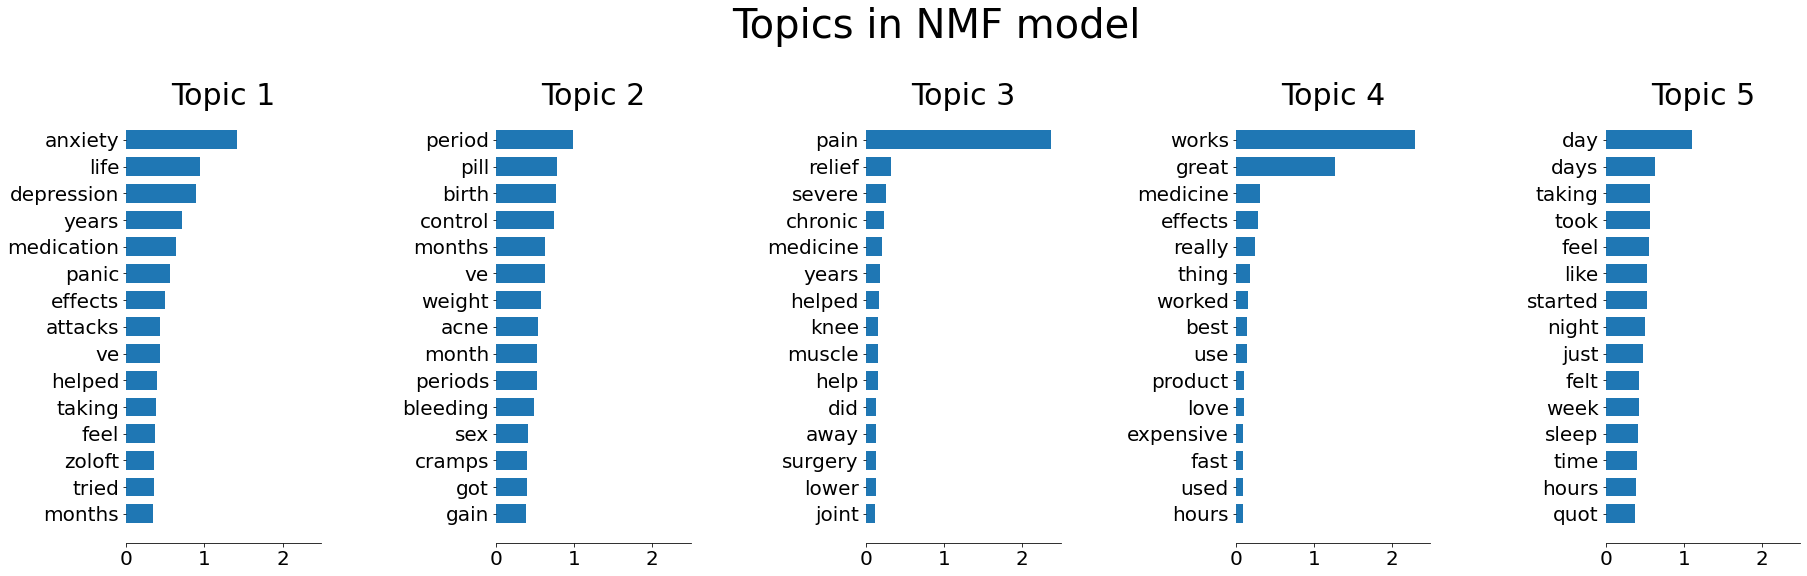

In [96]:
## plot for NMF model topics' top words
plot_top_words(model=nmf_model, 
               feature_names=tf_idf_df.columns,
               n_top_words=15,
               title='Topics in NMF model')

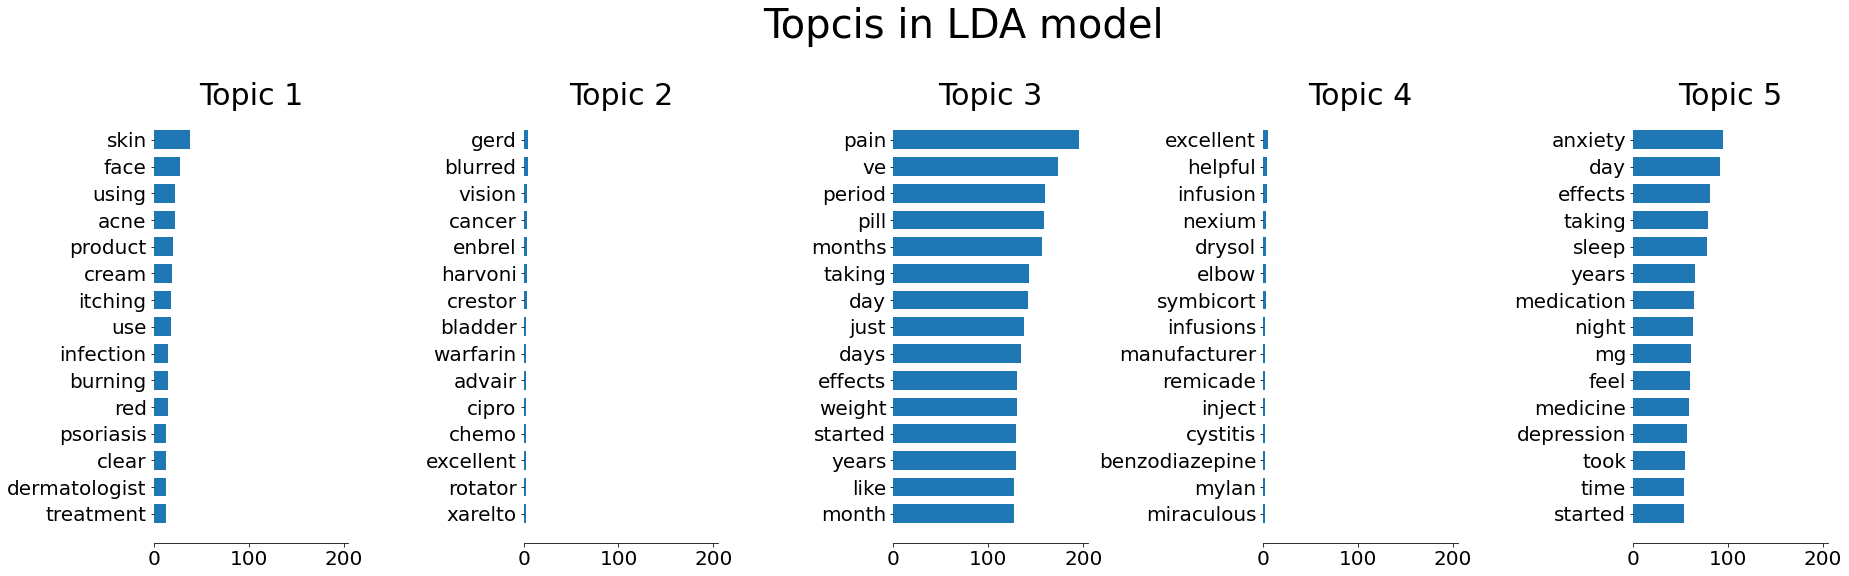

In [97]:
plot_top_words(model=lda_model,
              feature_names=tf_idf_df.columns,
              n_top_words=15,
              title='Topcis in LDA model')